# Modeling and Benchmarking

In [ ]:
!pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np

from tqdm.notebook import tqdm
from sklearn import preprocessing

from rdkit import Chem
from rdkit import RDLogger

from rdkit.Chem import DataStructs
from rdkit.Chem.rdMolDescriptors import GetHashedMorganFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonCountFP
from rdkit.Chem import rdReducedGraphs
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

import warnings
warnings.filterwarnings('ignore')

class scaler:
    def __init__(self, log=False):
        self.log = log
        self.offset = None
        self.scaler = None

    def fit(self, y):
        # make the values non-negative
        self.offset = np.min([np.min(y), 0.0])
        y = y.reshape(-1, 1) - self.offset
        # scale the input data
        if self.log:
            y = np.log10(y + 1.0)
        self.scaler = preprocessing.StandardScaler().fit(y)

    def transform(self, y):
        y = y.reshape(-1, 1) - self.offset
        # scale the input data
        if self.log:
            y = np.log10(y + 1.0)
        y_scale = self.scaler.transform(y)
        return y_scale

    def inverse_transform(self, y_scale):
        y = self.scaler.inverse_transform(y_scale.reshape(-1, 1))
        if self.log:
            y = 10.0**y - 1.0
        y = y + self.offset
        return y

def count_to_array(fingerprint):
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint, array)
    return array

def get_avalon_fingerprints(molecules, n_bits=1024):
    fingerprints = molecules.apply(lambda x: GetAvalonCountFP(x, nBits=n_bits))
    fingerprints = fingerprints.apply(count_to_array)
    return np.stack(fingerprints.values)

def get_morgan_fingerprints(molecules, n_bits=1024, radius=2):
    fingerprints = molecules.apply(lambda x:
        GetHashedMorganFingerprint(x, nBits=n_bits, radius=radius))
    fingerprints = fingerprints.apply(count_to_array)
    return np.stack(fingerprints.values)

def get_erg_fingerprints(molecules):
    fingerprints = molecules.apply(rdReducedGraphs.GetErGFingerprint)
    return np.stack(fingerprints.values)

def get_chosen_descriptors():
    chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
        'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
        'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3',
        'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
        'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2',
        'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount',
        'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA',
        'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge',
        'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge',
        'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
        'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles',
        'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors',
        'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
        'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings',
        'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
        'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5',
        'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1',
        'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
        'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',
        'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
        'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2',
        'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7',
        'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN',
        'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O',
        'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2',
        'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH',
        'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid',
        'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo',
        'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo',
        'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido',
        'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan',
        'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone',
        'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom',
        'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime',
        'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid',
        'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd',
        'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
        'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
        'fr_unbrch_alkane', 'fr_urea', 'qed']

    return chosen_descriptors

def get_rdkit_features(molecules):
    calculator = MolecularDescriptorCalculator(get_chosen_descriptors())
    X_rdkit = molecules.apply(
        lambda x: np.array(calculator.CalcDescriptors(x)))
    X_rdkit = np.vstack(X_rdkit.values)
    return X_rdkit

def get_fingerprints(smiles):
    RDLogger.DisableLog('rdApp.*')
    molecules = smiles.apply(Chem.MolFromSmiles)

    fingerprints = []
    fingerprints.append(get_morgan_fingerprints(molecules))
    fingerprints.append(get_avalon_fingerprints(molecules))
    fingerprints.append(get_erg_fingerprints(molecules))
    fingerprints.append(get_rdkit_features(molecules))

    return np.concatenate(fingerprints, axis=1)

In [ ]:
import pandas as pd

train = pd.read_csv("train_val.csv")
test = pd.read_csv("test.csv")
print(train.shape, test.shape)

train.head()

(7985, 3) (1997, 3)


,Drug_ID,Drug,Y
0,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
1,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
2,4-(dimethylamino)benzaldehyde,CN(C)c1ccc(C=O)cc1,-2.282769
3,2-methyl-1-phenylpropan-2-yl acetate,CC(=O)OC(C)(C)Cc1ccccc1,-2.394650
4,5-methoxy-1-[4-(trifluoromethyl)phenyl]pentan-...,COCCCCC(=O)c1ccc(C(F)(F)F)cc1,-3.544060


In [ ]:
!pip install lightgbm

In [ ]:
import joblib
import lightgbm as lgb
from tdc.benchmark_group import admet_group

group = admet_group(path = 'data/')

100%|██████████| 1.47M/1.47M [00:00<00:00, 4.36MiB/s]
Extracting zip file...
Done!


In [ ]:
!mkdir saved_models

In [ ]:
X_train = get_fingerprints(train['Drug'])
X_test = get_fingerprints(test['Drug'])

X_train.shape, X_test.shape

((7985, 2563), (1997, 2563))

In [ ]:
# seeds = [42]
seeds = [100, 200, 300, 400, 500]

if len(seeds) > 1:
    multiple_seed = True
else:
    multiple_seed = False

predictions_list = []
benchmark_name = "solubility_aqsoldb"

for seed in tqdm(seeds):
    predictions = {}
    Y_scaler = scaler(log=False)
    Y_scaler.fit(train['Y'].values)
    train['Y_scale'] = Y_scaler.transform(train['Y'].values)

    model = lgb.LGBMRegressor(
        objective='regression_l1',  # MAE objective
        metric='mae',
        n_estimators=1000,  # Number of boosting rounds
        learning_rate=0.05, # Step size shrinkage
        num_leaves=31,      # Maximum number of leaves in one tree
        max_depth=-1,       # No limit on tree depth
        min_child_samples=20, # Minimum number of data needed in a child leaf
        subsample=0.8,      # Fraction of samples used for fitting the individual base learners
        colsample_bytree=0.8, # Fraction of features used when building trees
        random_state=42,    # For reproducibility
        n_jobs=-1,          # Use all available cores
        reg_alpha=0.1,      # L1 regularization
        reg_lambda=0.1      # L2 regularization
    )

    model.fit(X_train, train['Y_scale'].values)
    y_pred_test = Y_scaler.inverse_transform(model.predict(X_test)).reshape(-1)

    model_filename = f"saved_models/{benchmark_name}_seed_{seed}.joblib"
    joblib.dump(model, model_filename)

    predictions[benchmark_name] = y_pred_test
    predictions_list.append(predictions)

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46956
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 2507
[LightGBM] [Info] Start training from score 0.124407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.319775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46956
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 2507
[LightGBM] [Info] Start training from score 0.124407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46956
[LightGBM] [Info] Number of data points in the train set: 7985, number of used features: 2507
[LightGBM] [Info] Sta

In [ ]:
if multiple_seed:
    results = group.evaluate_many(predictions_list)
else:
    results = group.evaluate(predictions)
print(results)

{'solubility_aqsoldb': [0.729, 0.0]}


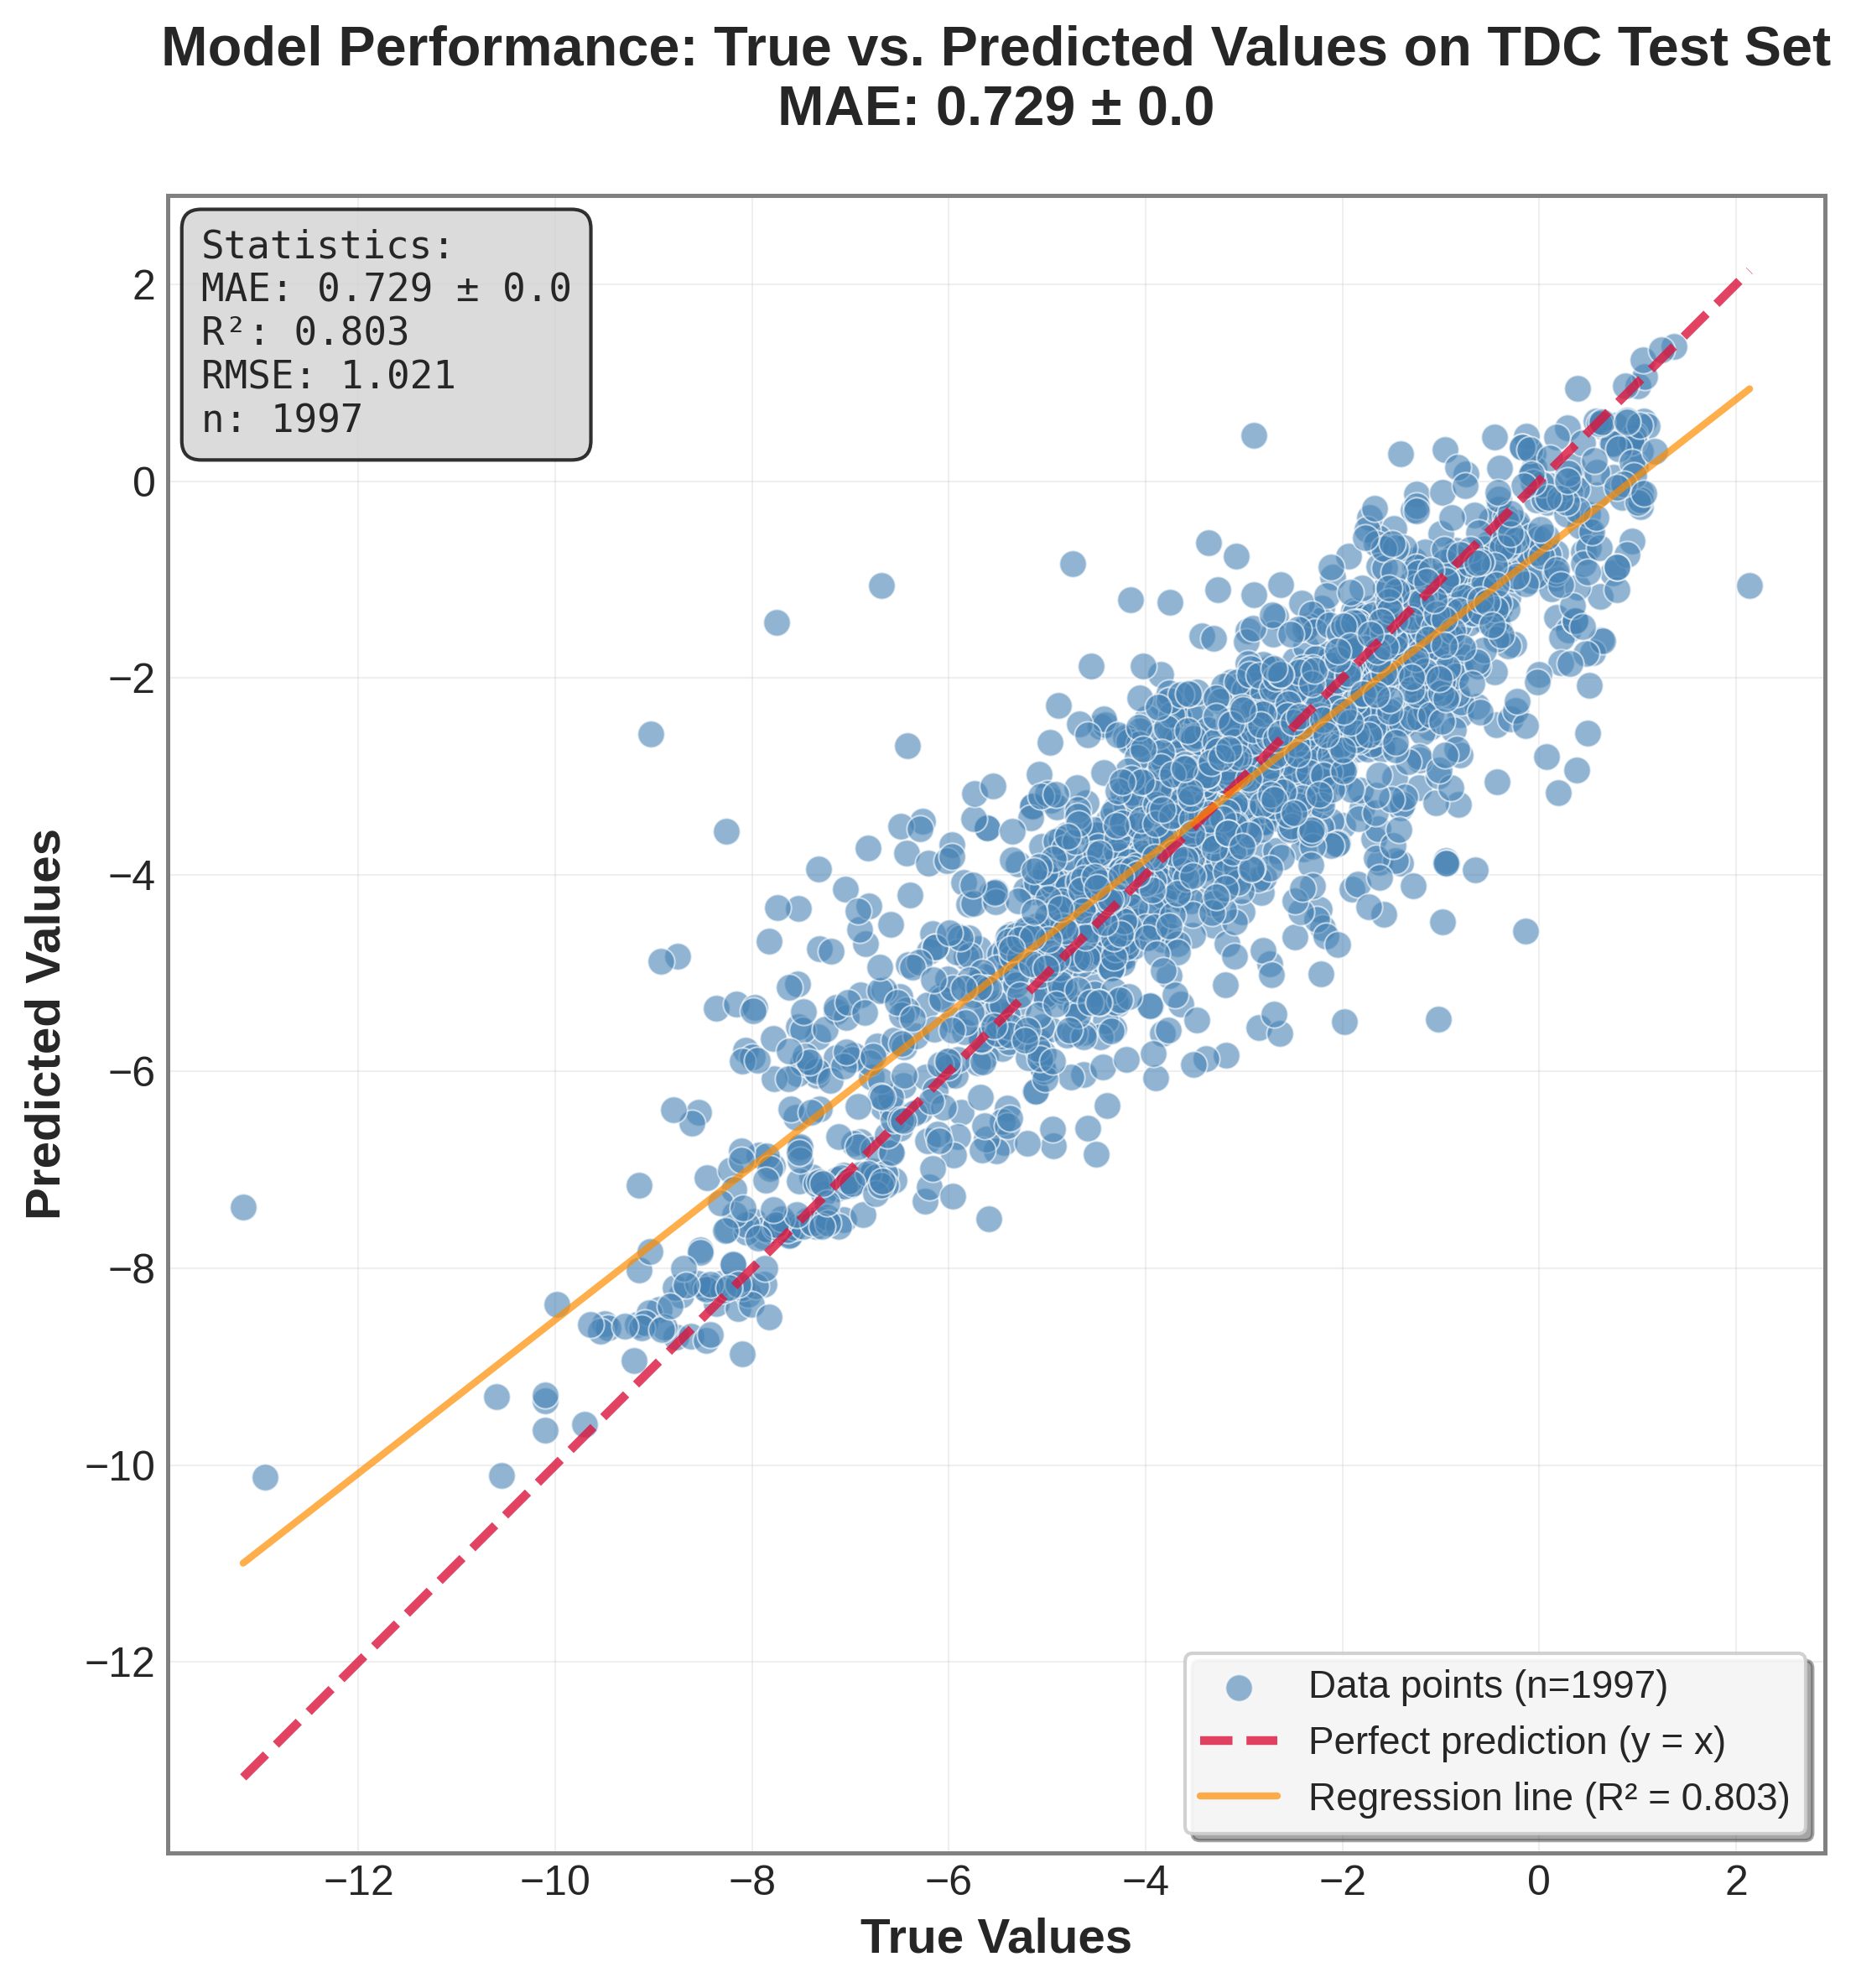

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create figure with higher DPI for crisp output
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)

# Calculate R² for additional statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(test["Y"], y_pred_test)
r_squared = r_value**2

# Create the scatter plot with enhanced styling
scatter = ax.scatter(test["Y"], y_pred_test,
                    alpha=0.6,
                    s=60,
                    c='steelblue',
                    edgecolors='white',
                    linewidth=0.5,
                    label=f'Data points (n={len(test["Y"])})')

# Perfect prediction line (y = x)
min_val = min(min(test["Y"]), min(y_pred_test))
max_val = max(max(test["Y"]), max(y_pred_test))
ax.plot([min_val, max_val], [min_val, max_val],
        color='crimson',
        linestyle='--',
        linewidth=2.5,
        alpha=0.8,
        label='Perfect prediction (y = x)')

# Add regression line
x_line = np.linspace(min_val, max_val, 100)
y_line = slope * x_line + intercept
ax.plot(x_line, y_line,
        color='darkorange',
        linestyle='-',
        linewidth=2,
        alpha=0.7,
        label=f'Regression line (R² = {r_squared:.3f})')

# Enhanced labels and title
ax.set_xlabel('True Values', fontsize=14, fontweight='bold')
ax.set_ylabel('Predicted Values', fontsize=14, fontweight='bold')
ax.set_title(f'Model Performance: True vs. Predicted Values on TDC Test Set\nMAE: {results[benchmark_name][0]} ± {results[benchmark_name][1]}',
             fontsize=16, fontweight='bold', pad=20)

# Customize grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

# Add statistics text box
textstr = f'Statistics:\nMAE: {results[benchmark_name][0]} ± {results[benchmark_name][1]}\nR²: {r_squared:.3f}\nRMSE: {np.sqrt(np.mean((test["Y"] - y_pred_test)**2)):.3f}\nn: {len(test["Y"])}'
props = dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, fontfamily='monospace')

# Legend with better positioning
ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True,
          fontsize=11, framealpha=0.9)

# Equal aspect ratio for better comparison
ax.set_aspect('equal', adjustable='box')

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)
ax.tick_params(axis='both', which='minor', width=0.8)

# Add subtle border
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_color('gray')

# Tight layout for better spacing
plt.tight_layout()

# For publication, save with high quality
plt.savefig('true_vs_predicted_values.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
# plt.savefig('true_vs_predicted_values.pdf', bbox_inches='tight',
#             facecolor='white', edgecolor='none')

plt.show()

# Prediction for Experimental Data

In [ ]:
df = pd.read_csv("/content/Hits for solubility and mouse microsomal half-life predictions.csv")

y_pred_exp = Y_scaler.inverse_transform(model.predict(get_fingerprints(df['SMILE']))).reshape(-1)

df["Solubility"] = y_pred_exp
df_sorted = df.sort_values(by='Solubility', ascending=False)
df_sorted.to_csv("solubility_pred.csv", index=False)

df_sorted

,ID,Drug Name,SMILE,Solubility
12,23,PHA-767491,O=C1C2=C(NC(C3=CC=NC=C3)=C2)CCN1,-2.261570
10,21,Dasatinib,O=C(C1=CN=C(S1)NC2=NC(C)=NC(N3CCN(CC3)CCO)=C2)...,-3.312738
11,22,Pazopanib,O=S(C1=CC(NC2=NC=CC(N(C3=CC4=NN(C(C)=C4C=C3)C)...,-3.591461
2,8,PF-477736,O=C([C@@H](C1CCCCC1)N)NC2=CC3=C(C(C=NNC4=O)=C(...,-3.600840
14,25,AZD-5438,O=S(C1=CC=C(NC2=NC(C3=CN=C(N3C(C)C)C)=CC=N2)C=...,-4.122546
1,7,Tanzisertib,O[C@H]1CC[C@H](NC2=NC=C3N=C(NC4=C(F)C=C(F)C=C4...,-4.226490
16,27,Ponatinib,CC1=C(C=C(C=C1)C(NC2=CC(C(F)(F)F)=C(C=C2)CN3CC...,-4.395211
7,18,Gefitinib,ClC1=C(C=CC(NC2=NC=NC3=C2C=C(C(OC)=C3)OCCCN4CC...,-4.407410
4,15,AEE-788,C[C@H](C1=CC=CC=C1)NC2=C(C=C3C(C=C4)=CC=C4CN5C...,-4.468946
9,20,Imatinib,CN(CC1)CCN1CC2=CC=C(C(NC3=CC=C(C)C(NC4=NC(C5=C...,-4.487959
